# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

# Clean data

## Import libraries

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib notebook

## Get data

In [3]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


## Prepare data

In [4]:
# Convert Date column to datetime objects and strip timezone info
df['Date'] = pd.DatetimeIndex(df['Date']).date

# List of leap year 29Feb's
febs = ['2008-02-29','2012-02-29']

# Convert to list of datetimeobjects
dates = [datetime.datetime.strptime(f, '%Y-%m-%d').date() for f in febs]

# Remove all occurances from Date column
df = df[~df['Date'].isin(dates)] 

# Convert to Celsius
df['Data_Value'] *= 0.1 

# Sory by date
df.sort_values(by=['Date'], inplace=True)

# Create Month and Day columns
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day

# Set months and days as MultiIndex
df.set_index(['Month', 'Day'], inplace=True)

# Get rid of ID column
df = df[['Date', 'Element', 'Data_Value']]

## Divide dataframe into smaller chunks

In [5]:
# Set cutoff date
cutoff_date = datetime.datetime.strptime('2015-01-01','%Y-%m-%d').date()

# Set dataframes for before and after cutoff date
df_before = df.loc[df['Date'] < cutoff_date]
df_after = df.loc[df['Date'] >= cutoff_date]

# Set MIN & MAX dataframes for 2005-2014
df_before_min = df_before.loc[df_before['Element'] == 'TMIN']
df_before_max = df_before.loc[df_before['Element'] == 'TMAX']

# Set MIN & MAX dataframes for 2015
df_after_min = df_after.loc[df_after['Element'] == 'TMIN']
df_after_max = df_after.loc[df_after['Element'] == 'TMAX']

# Set dataframes for daily min and max temperatures for 2005-2014
df_before_min_temp = df_before.groupby(level = ['Month', 'Day'])['Data_Value', 'Date'].min()
df_before_max_temp = df_before.groupby(level = ['Month', 'Day'])['Data_Value', 'Date'].max()

# Set dataframes for daily min and max temperatures for 2015
df_after_min_temp = df_after.groupby(level = ['Month', 'Day'])['Data_Value', 'Date'].min()
df_after_max_temp = df_after.groupby(level = ['Month', 'Day'])['Data_Value', 'Date'].max()

# Set dataframes for daily min and max temperatures of 2015 higher than 2005-2014
df_after_min_temp = df_after_min_temp[df_after_min_temp['Data_Value'] < df_before_min_temp['Data_Value']]
df_after_max_temp = df_after_max_temp[df_after_max_temp['Data_Value'] > df_before_max_temp['Data_Value']]       

# Create a yearly arrach of daytime objects 
dates = np.arange('2015-01-01', '2016-01-01', dtype='datetime64[D]')
df_before_min_temp['Dates'] = dates
df_before_max_temp['Dates'] = dates

# Set newly created array as new indices for 2005-2014 max temp dataframes
df_before_min_temp.set_index('Dates', inplace=True)
df_before_max_temp.set_index('Dates', inplace=True)

## Format the plot

<IPython.core.display.Javascript object>


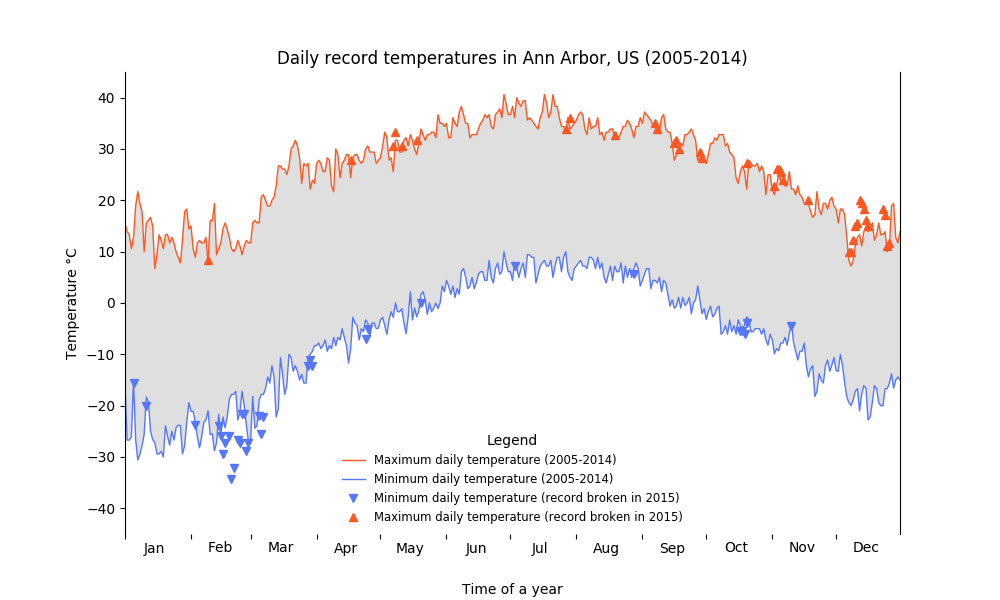

In [6]:
# Format the graph dates as month-day
frmt = mdates.DateFormatter('%m-%d')

# Set graph size to 16:9
fig, ax = plt.subplots(figsize = (10, 6))

# Strip empty spaces
ax.set_xlim([datetime.date(2015, 1, 1)], datetime.date(2015, 12, 31))
ax.set_ylim([-45, 45])

# Format tickmarks to show centered months and strip the center tick
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.tick_params(axis='x', which='minor', bottom=False)

# Remove frames and add grid
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.xaxis.grid(True)

## Plot

In [7]:
# Plot the line graph for highs and lows for 2005-2014
ax.plot(df_before_max_temp.index,
        df_before_max_temp['Data_Value'],
       '#ff5722',
       linewidth=1,
       label='Maximum daily temperature (2005-2014)')
ax.plot(df_before_min_temp.index,
        df_before_min_temp['Data_Value'],
       '#5677fc',
       linewidth=1,
       label='Minimum daily temperature (2005-2014)')

# Fill the space between line graphs
ax.fill_between(df_before_max_temp.index,
               df_before_min_temp['Data_Value'],
               df_before_max_temp['Data_Value'],
               facecolor='grey',
               alpha = 0.25)

# Plot the scatter plot for 2015
ax.plot(df_after_min_temp['Date'],
        df_after_min_temp['Data_Value'],
        'v',
        markersize = 6,
        color = '#5677fc',
        label = 'Minimum daily temperature (record broken in 2015)')
ax.plot(df_after_max_temp['Date'],
        df_after_max_temp['Data_Value'],
        '^',
        markersize = 6,
        color = '#ff5722',
        label = 'Maximum daily temperature (record broken in 2015)')

# Set typo
ax.legend(loc = 'lower center',
          fontsize = 'small',
          frameon = False,
          title = 'Legend')
ax.set_title('Daily record temperatures in Ann Arbor, US (2005-2014)')
plt.xlabel('Time of a year', labelpad = 20)
degree = '\u00b0'
plt.ylabel('Temperature {}C'.format(degree))

In [8]:
fig.savefig('assignment2.png')